In [1]:
pip install pyreadstat

     |████████████████████████████████| 1.9MB 6.2MB/s 


In [2]:
pip install shap

     |████████████████████████████████| 266kB 6.6MB/s 
  Created wheel for shap: filename=shap-0.32.1-cp36-cp36m-linux_x86_64.whl size=376817 sha256=05a8e370a96c5ac124e8dc70aea81a65c4195f42b4c7b9921293dffbe9809858
  Stored in directory: /root/.cache/pip/wheels/8e/b2/50/8fadb5a59789cb5bdeb01b800223be540651ae92915172050b
Successfully built shap


In [3]:
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [0]:
import pandas as pd
from pathlib import Path
import os
from fastai import *
from fastai.tabular import *
import pyreadstat
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
data_path = Path(r'/content/drive/My Drive/Colab Notebooks/Youth_Unemployment/data')

In [7]:
os.listdir(data_path)

['Unemployment_2004-2019_tassi_provinciale_plus.csv',
 'Demographic_2004-2019_provinciale.csv',
 'Unemployment_with_ra.csv',
 'Ita_spatialdata',
 'Unemployment_2017_merged.csv',
 'Demographic_2001-2017_composition_provinciale.csv',
 'Unemployment_with_ra_demcomp.csv',
 'Demographic_2016-2017_education_regionale.csv',
 'Unemployment_with_ra_demcomp_educat.csv',
 'Survey_2018Oct.sav',
 'cities_model',
 'individual_model',
 'Survey_variable-description.csv',
 'Survey_2018Oct_f.csv',
 'Survey_2018Apr.sav',
 'Survey_2018Jul.sav',
 'Survey_f.csv',
 'Survey_2017Oct.sav',
 'Survey_2018Jan.sav',
 'Survey_2017Jul.sav',
 'json_file.json']

In [0]:
#to load the original survey
#df, meta = pyreadstat.read_sav(os.path.join(data_path,'Survey_2018Oct.sav' ))

In [0]:
#to load the feature engineered survey
df = pd.read_csv(os.path.join(data_path,'Survey_f.csv'))

In [10]:
df.head()

,Unnamed: 0,IDNO,TITL,VERSION,RELEASE,ANNO,TRIM,WAVQUA,RIP5,RIP3,REG,PROVCM,GRACOM,NN2,RPN2,TFM,TN2,SG4,SG11,ETAM,CLETAD,CLETAQ,CLETAS,STACIM,AMATRI,RELPAR,SG13,NASSES,CITTAD,SG16,CITSES,SG18B,SG18D,SG18E,SG18F,SG18G,TISTUD,EDULEV,HATLEV,SG24A,SG24B,SG25,SG25_4,SG25_5,SG25_6,SG25_6PD,SG25_7,SG26,SG27A,SG27,COND3,COND10,GRACOM_is_NA,AMATRI_is_NA,NASSES_is_NA,CITSES_is_NA,SG18B_is_NA,SG18D_is_NA,SG18E_is_NA,SG18F_is_NA,SG18G_is_NA,SG24A_is_NA,SG24B_is_NA,SG25_is_NA,SG25_4_is_NA,SG25_5_is_NA,SG25_6_is_NA,SG25_6PD_is_NA,SG25_7_is_NA,SG26_is_NA,SG27A_is_NA,SG27_is_NA,REG_NAME,Population_M,Population_F,Population_T
0,0,SN202,Rilevazione Continua sulle Forze di Lavoro - O...,1.0 - 07/05/2019,17/04/2019,2018.0,4.0,1.0,3.0,2.0,11.0,42.0,NaN,1.0,1.0,8.0,1.0,3.0,2.0,37.0,4.0,6.0,9.0,2.0,2015.0,1.0,1.0,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,10.0,6.0,800.0,NaN,4.0,19.0,NaN,NaN,NaN,NaN,19.0,2010.0,NaN,NaN,1,1.0,1,0,1,1,1,1,1,1,1,1,0,0,1,1,1,1,0,0,1,1,Marche,740927.0,784344.0,1525271
1,1,SN202,Rilevazione Continua sulle Forze di Lavoro - O...,1.0 - 07/05/2019,17/04/2019,2018.0,4.0,1.0,3.0,2.0,11.0,42.0,NaN,1.0,2.0,8.0,1.0,3.0,1.0,36.0,4.0,6.0,9.0,2.0,2015.0,2.0,1.0,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,10.0,6.0,700.0,NaN,5.0,19.0,NaN,NaN,NaN,NaN,19.0,2010.0,NaN,NaN,1,1.0,1,0,1,1,1,1,1,1,1,1,0,0,1,1,1,1,0,0,1,1,Marche,740927.0,784344.0,1525271
2,2,SN202,Rilevazione Continua sulle Forze di Lavoro - O...,1.0 - 07/05/2019,17/04/2019,2018.0,4.0,2.0,1.0,1.0,7.0,210.0,10025.0,0.0,0.0,1.0,0.0,1.0,1.0,60.0,6.0,11.0,14.0,3.0,NaN,1.0,1.0,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,5.0,5.0,304.0,NaN,NaN,20.0,NaN,20.0,NaN,NaN,NaN,1976.0,NaN,NaN,3,8.0,0,1,1,1,1,1,1,1,1,1,1,0,1,0,1,1,1,0,1,1,Liguria,741760.0,808880.0,1550640
3,3,SN202,Rilevazione Continua sulle Forze di Lavoro - O...,1.0 - 07/05/2019,17/04/2019,2018.0,4.0,1.0,4.0,3.0,16.0,272.0,72006.0,1.0,2.0,8.0,1.0,4.0,1.0,51.0,5.0,9.0,12.0,2.0,1992.0,1.0,1.0,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,10.0,6.0,700.0,NaN,5.0,9.0,NaN,NaN,NaN,NaN,9.0,997.0,NaN,24.0,1,1.0,0,0,1,1,1,1,1,1,1,1,0,0,1,1,1,1,0,0,1,0,Puglia,1959903.0,2069150.0,4029053
4,4,SN202,Rilevazione Continua sulle Forze di Lavoro - O...,1.0 - 07/05/2019,17/04/2019,2018.0,4.0,1.0,4.0,3.0,16.0,272.0,72006.0,1.0,1.0,8.0,1.0,4.0,2.0,48.0,5.0,8.0,11.0,2.0,1992.0,2.0,1.0,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,5.0,5.0,304.0,NaN,NaN,20.0,NaN,20.0,NaN,NaN,NaN,997.0,NaN,18.0,3,8.0,0,0,1,1,1,1,1,1,1,1,1,0,1,0,1,1,1,0,1,0,Puglia,1959903.0,2069150.0,4029053


In [11]:
df.shape

(166755, 76)

##Explore the features (only run if Original Survey)

The features are encoded with a title that reflects the type of questio being posed during the questionnaire, we will list them below in a dictionary. This is how the survey is conducted:

the first section covers the employment status during the interview’s week, dealing with questions about the type of work, hours worked, motivations about the unemployment status, the type of contract. **We are only interested in this section in predicting for unemployment**

The second section – reserved for employed people – covers the main job, investigating, in particular, the position in the profession, the industry in which he works, the company he works for, working full-time or part-time and reasons for his selection, working hours, overtime hours, shift work, job transfer, salary, job satisfaction.

The third section – always reserved for employed people – concerns the secondary work (if any). It’s exclusively addressed to respondents who carry out another activity compared to the main one and only detects certain information such as the type of activity, type of contract, occupation, the economic sector he works in.

The fourth section – for unemployed people – collects information about previous work experiences: last work, type of contract, occupation, economic sector, the reasons why it stopped working.

The fifth section deals with the job search. It investigates the reason for seeking a job, the actions put in place to look for it, the channels used to look for and the type of work sought.

The sixth section deals with employment and temp agencies and investigates their use by the respondents: the number of contacts, the reason for contact, services required.

The seventh section covers education and vocational education. It deals with the training courses respondents are attending.

The last section focuses on the auto-perception of their employment status, compared to the previous year.

In [0]:
#drop all columns after COND3.
col_list = list(df.columns)
#col_drop = col_list[col_list.index('COND3') + 1:]
#df.drop(columns= col_drop, inplace=True)

In [0]:
#df.shape

##Prepare The Data

###Split Model

In [0]:
model_path = os.path.join(data_path, 'individual_model')

In [0]:
#create test df
#msk = np.random.rand(len(df)) < 0.9
#train_df = df[msk]
#test_df = df[~msk]

In [0]:
#save (or load) both dataframes so they can be used next time

#train_df.to_csv((os.path.join(model_path, 'train.csv')))
#test_df.to_csv((os.path.join(model_path, 'test.csv')))
train_df = pd.read_csv(os.path.join(model_path, 'train.csv'))
test_df = pd.read_csv(os.path.join(model_path, 'test.csv'))

In [17]:
len(train_df), len(test_df)

(150259, 16496)

In [0]:
col_drop = ['Unnamed: 0', 'COND10']
train_df.drop(columns= col_drop, inplace=True)
test_df.drop(columns= col_drop, inplace=True)
col_drop = ['Unnamed: 0', 'COND10']
df.drop(columns= col_drop, inplace=True)

##preparation

In [19]:
cat_l = list(df.columns)
idx_drop_1 = cat_l.index('COND3')
cat_l.pop(idx_drop_1)

'COND3'

In [39]:
cat_l

['IDNO',
 'TITL',
 'VERSION',
 'RELEASE',
 'ANNO',
 'TRIM',
 'WAVQUA',
 'RIP5',
 'RIP3',
 'REG',
 'PROVCM',
 'GRACOM',
 'NN2',
 'RPN2',
 'TFM',
 'TN2',
 'SG4',
 'SG11',
 'ETAM',
 'CLETAD',
 'CLETAQ',
 'CLETAS',
 'STACIM',
 'AMATRI',
 'RELPAR',
 'SG13',
 'NASSES',
 'CITTAD',
 'SG16',
 'CITSES',
 'SG18B',
 'SG18D',
 'SG18E',
 'SG18F',
 'SG18G',
 'TISTUD',
 'EDULEV',
 'HATLEV',
 'SG24A',
 'SG24B',
 'SG25',
 'SG25_4',
 'SG25_5',
 'SG25_6',
 'SG25_6PD',
 'SG25_7',
 'SG26',
 'SG27A',
 'SG27',
 'GRACOM_is_NA',
 'AMATRI_is_NA',
 'NASSES_is_NA',
 'CITSES_is_NA',
 'SG18B_is_NA',
 'SG18D_is_NA',
 'SG18E_is_NA',
 'SG18F_is_NA',
 'SG18G_is_NA',
 'SG24A_is_NA',
 'SG24B_is_NA',
 'SG25_is_NA',
 'SG25_4_is_NA',
 'SG25_5_is_NA',
 'SG25_6_is_NA',
 'SG25_6PD_is_NA',
 'SG25_7_is_NA',
 'SG26_is_NA',
 'SG27A_is_NA',
 'SG27_is_NA']

In [20]:
idx_drop_2 = cat_l.index('REG_NAME')
cat_l.pop(idx_drop_2)

'REG_NAME'

In [21]:
idx_drop_3 = cat_l.index('Population_T')
cat_l.pop(idx_drop_3)

'Population_T'

In [22]:
idx_drop_4 = cat_l.index('Population_F')
cat_l.pop(idx_drop_4)

'Population_F'

In [23]:
idx_drop_5 = cat_l.index('Population_M')
cat_l.pop(idx_drop_5)

'Population_M'

In [0]:
cat_vars = cat_l
cont_vars = ['Population_T', 'Population_F', 'Population_M']
dep_var = 'COND3'

In [0]:
df = train_df[cat_vars + cont_vars + [dep_var]].copy()

In [26]:
df.shape

(150259, 73)

In [27]:
df.head()

,IDNO,TITL,VERSION,RELEASE,ANNO,TRIM,WAVQUA,RIP5,RIP3,REG,PROVCM,GRACOM,NN2,RPN2,TFM,TN2,SG4,SG11,ETAM,CLETAD,CLETAQ,CLETAS,STACIM,AMATRI,RELPAR,SG13,NASSES,CITTAD,SG16,CITSES,SG18B,SG18D,SG18E,SG18F,SG18G,TISTUD,EDULEV,HATLEV,SG24A,SG24B,SG25,SG25_4,SG25_5,SG25_6,SG25_6PD,SG25_7,SG26,SG27A,SG27,GRACOM_is_NA,AMATRI_is_NA,NASSES_is_NA,CITSES_is_NA,SG18B_is_NA,SG18D_is_NA,SG18E_is_NA,SG18F_is_NA,SG18G_is_NA,SG24A_is_NA,SG24B_is_NA,SG25_is_NA,SG25_4_is_NA,SG25_5_is_NA,SG25_6_is_NA,SG25_6PD_is_NA,SG25_7_is_NA,SG26_is_NA,SG27A_is_NA,SG27_is_NA,Population_T,Population_F,Population_M,COND3
0,SN202,Rilevazione Continua sulle Forze di Lavoro - O...,1.0 - 07/05/2019,17/04/2019,2018.0,4.0,1.0,3.0,2.0,11.0,42.0,NaN,1.0,1.0,8.0,1.0,3.0,2.0,37.0,4.0,6.0,9.0,2.0,2015.0,1.0,1.0,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,10.0,6.0,800.0,NaN,4.0,19.0,NaN,NaN,NaN,NaN,19.0,2010.0,NaN,NaN,1,0,1,1,1,1,1,1,1,1,0,0,1,1,1,1,0,0,1,1,1525271,784344.0,740927.0,1
1,SN202,Rilevazione Continua sulle Forze di Lavoro - O...,1.0 - 07/05/2019,17/04/2019,2018.0,4.0,1.0,3.0,2.0,11.0,42.0,NaN,1.0,2.0,8.0,1.0,3.0,1.0,36.0,4.0,6.0,9.0,2.0,2015.0,2.0,1.0,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,10.0,6.0,700.0,NaN,5.0,19.0,NaN,NaN,NaN,NaN,19.0,2010.0,NaN,NaN,1,0,1,1,1,1,1,1,1,1,0,0,1,1,1,1,0,0,1,1,1525271,784344.0,740927.0,1
2,SN202,Rilevazione Continua sulle Forze di Lavoro - O...,1.0 - 07/05/2019,17/04/2019,2018.0,4.0,2.0,1.0,1.0,7.0,210.0,10025.0,0.0,0.0,1.0,0.0,1.0,1.0,60.0,6.0,11.0,14.0,3.0,NaN,1.0,1.0,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,5.0,5.0,304.0,NaN,NaN,20.0,NaN,20.0,NaN,NaN,NaN,1976.0,NaN,NaN,0,1,1,1,1,1,1,1,1,1,1,0,1,0,1,1,1,0,1,1,1550640,808880.0,741760.0,3
3,SN202,Rilevazione Continua sulle Forze di Lavoro - O...,1.0 - 07/05/2019,17/04/2019,2018.0,4.0,1.0,4.0,3.0,16.0,272.0,72006.0,1.0,2.0,8.0,1.0,4.0,1.0,51.0,5.0,9.0,12.0,2.0,1992.0,1.0,1.0,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,10.0,6.0,700.0,NaN,5.0,9.0,NaN,NaN,NaN,NaN,9.0,997.0,NaN,24.0,0,0,1,1,1,1,1,1,1,1,0,0,1,1,1,1,0,0,1,0,4029053,2069150.0,1959903.0,1
4,SN202,Rilevazione Continua sulle Forze di Lavoro - O...,1.0 - 07/05/2019,17/04/2019,2018.0,4.0,1.0,4.0,3.0,16.0,272.0,72006.0,1.0,1.0,8.0,1.0,4.0,2.0,48.0,5.0,8.0,11.0,2.0,1992.0,2.0,1.0,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,5.0,5.0,304.0,NaN,NaN,20.0,NaN,20.0,NaN,NaN,NaN,997.0,NaN,18.0,0,0,1,1,1,1,1,1,1,1,1,0,1,0,1,1,1,0,1,0,4029053,2069150.0,1959903.0,3


In [0]:
df.reset_index(drop=True, inplace=True)

In [0]:
#transform COND3 (dependent variable) to 'int' type to avoid later errors with Float
df = df.assign(COND3=df.COND3.astype('int'))

In [0]:
#create valid_idx
msk = np.random.rand(len(df)) < 0.8
train_df = df[msk]
valid_df = df[~msk]
valid_idx = valid_df.index

In [31]:
valid_idx

Int64Index([    12,     13,     14,     19,     21,     24,     34,     36,
                38,     41,
            ...
            150214, 150215, 150218, 150224, 150226, 150228, 150230, 150236,
            150237, 150248],
           dtype='int64', length=29798)

In [32]:
train_df.fillna(int(99999), inplace=True) #fill na values with 99999 to allow for categorization

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4259: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  **kwargs


In [0]:
procs=[FillMissing, Categorify, Normalize]

data = TabularDataBunch.from_df(path=model_path, df=df, dep_var=dep_var, valid_idx=valid_idx, procs=procs, cat_names=cat_vars, cont_names=cont_vars)

In [34]:
(cat_x,cont_x),y = next(iter(data.train_dl))
for o in (cat_x, cont_x, y): print(to_np(o[:5]))

[[1 1 3 1 ... 1 2 1 1]
 [1 1 3 1 ... 2 2 1 1]
 [3 3 2 2 ... 2 2 1 1]
 [2 2 1 3 ... 1 2 1 1]
 [1 1 3 1 ... 2 2 1 1]]
[[ 2.254844  2.326434  2.350275]
 [ 0.726558  0.635234  0.591887]
 [-0.864708 -1.185813 -1.17614 ]
 [-0.822926 -1.145875 -1.121488]
 [ 0.370855  0.203764  0.222159]]
[0 1 0 1 0]


##Model

In [0]:
#debug Accuracy function
def accuracy(input:Tensor, targs:Tensor)->Rank0Tensor:
    "Computes accuracy with `targs` when `input` is bs * n_classes."
    n = targs.shape[0]
    input = input.argmax(dim=-1).view(n,-1)
    targs = targs.view(n,-1)
    return (input==targs).float().mean()

In [0]:
#kappa score is poarticularly useful for non-balanced datasets
kappa = KappaScore()
kappa.weights = "quadratic"

In [0]:
from torch.utils.data.sampler import WeightedRandomSampler

__all__ = ['OverSamplingCallback']

class OverSamplingCallback(LearnerCallback):
    def __init__(self,learn:Learner):
        super().__init__(learn)
        self.labels = self.learn.data.train_dl.dataset.y.items
        _, counts = np.unique(self.labels,return_counts=True)
        self.weights = torch.DoubleTensor((1/counts)[self.labels])

    def on_train_begin(self, **kwargs):
        self.learn.data.train_dl.dl.batch_sampler = BatchSampler(WeightedRandomSampler(self.weights,len(self.learn.data.train_dl.dataset)), self.learn.data.train_dl.batch_size,False)         

In [0]:
from fastai.callbacks import oversampling
learn = tabular_learner(data, layers=[1000,500], ps=[0.001,0.01], emb_drop=0.04, metrics=[FBeta(average="binary"), kappa, accuracy], callback_fns=[OverSamplingCallback,ShowGraph])

In [0]:
#add a linear layer with out_fetures=num_classes
learn.model.layers[8] = nn.Linear(in_features=500, out_features=2, bias=True)
learn.model.cuda();

In [0]:
def CrossEntropyFlat(*args, axis:int=-1, **kwargs):
    "Same as `nn.CrossEntropyLoss`, but flattens input and target."
    return FlattenedLoss(nn.CrossEntropyLoss, *args, axis=axis, **kwargs)

In [41]:
#assign more weight in loss function to the imbalanced class (weight[class] = 1/len(class))
value_counts = df[dep_var].value_counts()
tot = value_counts.sum()
weights = [1-(value_counts[1]/tot), 1-(value_counts[3]/tot)]
class_weights = torch.FloatTensor(weights).cuda()
learn.loss_func = CrossEntropyFlat() #weight=class_weights
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

##Train

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


In [0]:
learn.data.c

2

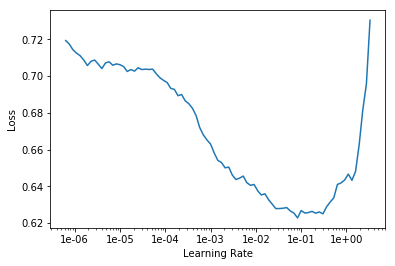

In [0]:
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(5, 1e-3)

epoch,train_loss,valid_loss,f_beta,kappa_score,accuracy,time


KeyboardInterrupt: ignored

In [0]:
learn.save('16')

In [0]:
learn.lr_find()

In [0]:
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(5, slice(3e-5), wd=0.3)

In [0]:
learn.save('16-2')

In [0]:
prediction = learn.predict(df.loc[200])
prediction

In [0]:
train_df.shape

##Interpretation

In [0]:
#load the correct model for interpretation
learn = learn.load('16')

In [0]:
defaults.device

In [0]:
defaults.device = torch.device("cpu")
defaults.device

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

In [0]:
interp.plot_confusion_matrix()

In [0]:
#actual, predicted, number of times that the model was wrong
interp.most_confused()

In [0]:
defaults.device = torch.device("cuda")
defaults.device

##ML models

In [0]:
train_df.reset_index(drop=True, inplace=True)

In [36]:
train_df.head()

,IDNO,TITL,VERSION,RELEASE,ANNO,TRIM,WAVQUA,RIP5,RIP3,REG,PROVCM,GRACOM,NN2,RPN2,TFM,TN2,SG4,SG11,ETAM,CLETAD,CLETAQ,CLETAS,STACIM,AMATRI,RELPAR,SG13,NASSES,CITTAD,SG16,CITSES,SG18B,SG18D,SG18E,SG18F,SG18G,TISTUD,EDULEV,HATLEV,SG24A,SG24B,SG25,SG25_4,SG25_5,SG25_6,SG25_6PD,SG25_7,SG26,SG27A,SG27,GRACOM_is_NA,AMATRI_is_NA,NASSES_is_NA,CITSES_is_NA,SG18B_is_NA,SG18D_is_NA,SG18E_is_NA,SG18F_is_NA,SG18G_is_NA,SG24A_is_NA,SG24B_is_NA,SG25_is_NA,SG25_4_is_NA,SG25_5_is_NA,SG25_6_is_NA,SG25_6PD_is_NA,SG25_7_is_NA,SG26_is_NA,SG27A_is_NA,SG27_is_NA,Population_T,Population_F,Population_M,COND3
0,SN202,Rilevazione Continua sulle Forze di Lavoro - O...,1.0 - 07/05/2019,17/04/2019,2018.0,4.0,1.0,3.0,2.0,11.0,42.0,99999.0,1.0,1.0,8.0,1.0,3.0,2.0,37.0,4.0,6.0,9.0,2.0,2015.0,1.0,1.0,99999.0,1.0,1.0,99999.0,99999.0,99999.0,99999.0,99999.0,99999.0,10.0,6.0,800.0,99999.0,4.0,19.0,99999.0,99999.0,99999.0,99999.0,19.0,2010.0,99999.0,99999.0,1,0,1,1,1,1,1,1,1,1,0,0,1,1,1,1,0,0,1,1,1525271,784344.0,740927.0,1
1,SN202,Rilevazione Continua sulle Forze di Lavoro - O...,1.0 - 07/05/2019,17/04/2019,2018.0,4.0,1.0,3.0,2.0,11.0,42.0,99999.0,1.0,2.0,8.0,1.0,3.0,1.0,36.0,4.0,6.0,9.0,2.0,2015.0,2.0,1.0,99999.0,1.0,1.0,99999.0,99999.0,99999.0,99999.0,99999.0,99999.0,10.0,6.0,700.0,99999.0,5.0,19.0,99999.0,99999.0,99999.0,99999.0,19.0,2010.0,99999.0,99999.0,1,0,1,1,1,1,1,1,1,1,0,0,1,1,1,1,0,0,1,1,1525271,784344.0,740927.0,1
2,SN202,Rilevazione Continua sulle Forze di Lavoro - O...,1.0 - 07/05/2019,17/04/2019,2018.0,4.0,2.0,1.0,1.0,7.0,210.0,10025.0,0.0,0.0,1.0,0.0,1.0,1.0,60.0,6.0,11.0,14.0,3.0,99999.0,1.0,1.0,99999.0,1.0,1.0,99999.0,99999.0,99999.0,99999.0,99999.0,99999.0,5.0,5.0,304.0,99999.0,99999.0,20.0,99999.0,20.0,99999.0,99999.0,99999.0,1976.0,99999.0,99999.0,0,1,1,1,1,1,1,1,1,1,1,0,1,0,1,1,1,0,1,1,1550640,808880.0,741760.0,3
3,SN202,Rilevazione Continua sulle Forze di Lavoro - O...,1.0 - 07/05/2019,17/04/2019,2018.0,4.0,1.0,4.0,3.0,16.0,272.0,72006.0,1.0,2.0,8.0,1.0,4.0,1.0,51.0,5.0,9.0,12.0,2.0,1992.0,1.0,1.0,99999.0,1.0,1.0,99999.0,99999.0,99999.0,99999.0,99999.0,99999.0,10.0,6.0,700.0,99999.0,5.0,9.0,99999.0,99999.0,99999.0,99999.0,9.0,997.0,99999.0,24.0,0,0,1,1,1,1,1,1,1,1,0,0,1,1,1,1,0,0,1,0,4029053,2069150.0,1959903.0,1
4,SN202,Rilevazione Continua sulle Forze di Lavoro - O...,1.0 - 07/05/2019,17/04/2019,2018.0,4.0,1.0,4.0,3.0,16.0,272.0,72006.0,1.0,1.0,8.0,1.0,4.0,2.0,48.0,5.0,8.0,11.0,2.0,1992.0,2.0,1.0,99999.0,1.0,1.0,99999.0,99999.0,99999.0,99999.0,99999.0,99999.0,5.0,5.0,304.0,99999.0,99999.0,20.0,99999.0,20.0,99999.0,99999.0,99999.0,997.0,99999.0,18.0,0,0,1,1,1,1,1,1,1,1,1,0,1,0,1,1,1,0,1,0,4029053,2069150.0,1959903.0,3


In [37]:
col_drop = ['IDNO', 'TITL', 'VERSION', 'RELEASE']
train_df.drop(columns= col_drop, inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [46]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
import joblib

cat_vars = [x for x in cat_vars if x not in col_drop]
pipeline1 = Pipeline([
                ('OneHotEncoder', OneHotEncoder())
            ])
pipeline1.fit(train_df[cat_vars])
joblib.dump(pipeline1, os.path.join(data_path, "pipeline1.joblib"))

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


['/content/drive/My Drive/Colab Notebooks/Youth_Unemployment/data/pipeline1.joblib']

In [38]:
from sklearn.preprocessing import OneHotEncoder
cat_vars = [x for x in cat_vars if x not in col_drop]
OneHotEncoder().fit_transform(train_df[cat_vars])

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


<120461x1199 sparse matrix of type '<class 'numpy.float64'>'
	with 7829965 stored elements in Compressed Sparse Row format>

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_df[cat_vars[3:]+cont_vars], train_df[dep_var], test_size=0.33)

In [47]:
weight_ratio = 0.6
w_array = np.array([1]*y_train.shape[0]).astype('float')
w_array[y_train==3] = weight_ratio
w_array[y_train==1] = 1- weight_ratio
w_array[60:]

array([0.4, 0.4, 0.4, 0.4, ..., 0.4, 0.4, 0.4, 0.4])

In [48]:
X_train.head()

,RIP5,RIP3,REG,PROVCM,GRACOM,NN2,RPN2,TFM,TN2,SG4,SG11,ETAM,CLETAD,CLETAQ,CLETAS,STACIM,AMATRI,RELPAR,SG13,NASSES,CITTAD,SG16,CITSES,SG18B,SG18D,SG18E,SG18F,SG18G,TISTUD,EDULEV,HATLEV,SG24A,SG24B,SG25,SG25_4,SG25_5,SG25_6,SG25_6PD,SG25_7,SG26,SG27A,SG27,GRACOM_is_NA,AMATRI_is_NA,NASSES_is_NA,CITSES_is_NA,SG18B_is_NA,SG18D_is_NA,SG18E_is_NA,SG18F_is_NA,SG18G_is_NA,SG24A_is_NA,SG24B_is_NA,SG25_is_NA,SG25_4_is_NA,SG25_5_is_NA,SG25_6_is_NA,SG25_6PD_is_NA,SG25_7_is_NA,SG26_is_NA,SG27A_is_NA,SG27_is_NA,Population_T,Population_F,Population_M
68966,1.0,1.0,1.0,6.0,99999.0,1.0,2.0,8.0,1.0,4.0,1.0,55.0,6.0,10.0,13.0,2.0,1989.0,1.0,1.0,99999.0,1.0,1.0,99999.0,99999.0,99999.0,99999.0,99999.0,99999.0,5.0,5.0,304.0,99999.0,99999.0,22.0,99999.0,22.0,99999.0,99999.0,99999.0,1982.0,99999.0,99999.0,1,0,1,1,1,1,1,1,1,1,1,0,1,0,1,1,1,0,1,1,4356406,2241327.0,2115079.0
93806,2.0,1.0,6.0,93.0,99999.0,1.0,3.0,8.0,1.0,5.0,2.0,30.0,3.0,5.0,8.0,1.0,99999.0,6.0,2.0,423.0,3.0,2.0,423.0,2005.0,4.0,1.0,99999.0,99999.0,5.0,5.0,304.0,99999.0,99999.0,50.0,99999.0,50.0,99999.0,99999.0,99999.0,2016.0,6.0,99999.0,1,1,0,0,0,0,0,1,1,1,1,0,1,0,1,1,1,0,0,1,1215220,99999.0,99999.0
50459,1.0,1.0,1.0,5.0,99999.0,1.0,1.0,8.0,1.0,3.0,2.0,53.0,5.0,9.0,12.0,2.0,1991.0,2.0,1.0,99999.0,1.0,1.0,99999.0,99999.0,99999.0,99999.0,99999.0,99999.0,5.0,5.0,304.0,99999.0,99999.0,28.0,99999.0,28.0,99999.0,99999.0,99999.0,1984.0,99999.0,99999.0,1,0,1,1,1,1,1,1,1,1,1,0,1,0,1,1,1,0,1,1,4356406,2241327.0,2115079.0
14106,4.0,3.0,13.0,69.0,99999.0,1.0,2.0,8.0,1.0,4.0,1.0,35.0,4.0,6.0,9.0,2.0,2014.0,1.0,1.0,99999.0,1.0,1.0,99999.0,99999.0,99999.0,99999.0,99999.0,99999.0,5.0,5.0,304.0,99999.0,99999.0,30.0,99999.0,30.0,99999.0,99999.0,99999.0,998.0,99999.0,19.0,1,0,1,1,1,1,1,1,1,1,1,0,1,0,1,1,1,0,1,0,1311580,671444.0,640136.0
21680,4.0,3.0,15.0,62.0,99999.0,0.0,0.0,1.0,0.0,1.0,1.0,63.0,6.0,11.0,14.0,1.0,99999.0,1.0,1.0,99999.0,1.0,1.0,99999.0,99999.0,99999.0,99999.0,99999.0,99999.0,3.0,3.0,200.0,99999.0,99999.0,99999.0,99999.0,99999.0,99999.0,99999.0,99999.0,1968.0,99999.0,99999.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,5801692,2973202.0,2828490.0


In [49]:
X_train.shape

(80395, 65)

In [47]:
X_train.dtype()

NameError: ignored

###XGBoost

In [51]:
# fit model to training data
XGB = XGBClassifier(n_estimators=100)
XGB.fit(X_train, y_train)

# make predictions for test data
y_pred = XGB.predict(X_test)

#classification report
XGB_classr = classification_report(y_pred,y_test)
XGB_classr_dict = classification_report(y_pred,y_test, output_dict=True)
print(XGB_classr)

#confusion matrix
XGB_cm = confusion_matrix(y_pred,y_test)
print(XGB_cm)

#Accuracy Score
XGB_acc = accuracy_score(y_pred,y_test)
print("Accuracy: %.2f%%" % (XGB_acc * 100.0))

              precision    recall  f1-score   support

           1       0.85      0.78      0.81     25736
           3       0.65      0.75      0.70     13862

    accuracy                           0.77     39598
   macro avg       0.75      0.77      0.75     39598
weighted avg       0.78      0.77      0.77     39598

[[20007  5729]
 [ 3420 10442]]
Accuracy: 76.90%


###K-nearest neighbors

In [0]:
from sklearn.neighbors import KNeighborsClassifier
# fit model to training data
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

# make predictions for test data
y_pred = knn.predict(X_test)

#classification report
knn_classr = classification_report(y_pred,y_test)
knn_classr_dict = classification_report(y_pred,y_test, output_dict=True)
print(knn_classr)

#confusion matrix
knn_cm = confusion_matrix(y_pred,y_test)
print(knn_cm)

#Accuracy Score
knn_acc = accuracy_score(y_pred,y_test)
print("Accuracy: %.2f%%" % (knn_acc * 100.0))

###Random Forest Classifier

In [0]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train, y_train)

# make predictions for test data
y_pred = rfc.predict(X_test)

#classification report
rfc_classr = classification_report(y_pred,y_test)
rfc_classr_dict = classification_report(y_pred,y_test, output_dict=True)
print(rfc_classr)

#confusion matrix
rfc_cm = confusion_matrix(y_pred,y_test)
print(rfc_cm)

#Accuracy Score
rfc_acc = accuracy_score(y_pred,y_test)
print("Accuracy: %.2f%%" % (rfc_acc * 100.0))

              precision    recall  f1-score   support

           1       0.86      0.81      0.83     24783
           3       0.71      0.78      0.74     14924

    accuracy                           0.80     39707
   macro avg       0.78      0.79      0.79     39707
weighted avg       0.80      0.80      0.80     39707

[[20042  4741]
 [ 3300 11624]]
Accuracy: 79.75%


###Support Vector Machine

In [0]:
from sklearn.svm import SVC
svc = SVC()
svc.fit(X_train, y_train)

# make predictions for test data
y_pred = svc.predict(X_test)

#classification report
svc_classr = classification_report(y_pred,y_test)
svc_classr_dict = classification_report(y_pred,y_test, output_dict=True)
print(svc_classr)

#confusion matrix
svc_cm = confusion_matrix(y_pred,y_test)
print(svc_cm)

#Accuracy Score
svc_acc = accuracy_score(y_pred,y_test)
print("Accuracy: %.2f%%" % (svc_acc * 100.0))

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


let's compare the results between different models

In [0]:
results = pd.DataFrame({
    'Model': [ 'XGBoost','KNN', 'Random Forest'],
    'accuracy': [XGB_acc, knn_acc, rfc_acc],
    'precision': [XGB_classr_dict['weighted avg']['precision'], knn_classr_dict['weighted avg']['precision'], rfc_classr_dict['weighted avg']['precision']],
    'recall': [XGB_classr_dict['weighted avg']['recall'], knn_classr_dict['weighted avg']['recall'], rfc_classr_dict['weighted avg']['recall']],
    'f1-score': [XGB_classr_dict['weighted avg']['f1-score'], knn_classr_dict['weighted avg']['f1-score'], rfc_classr_dict['weighted avg']['f1-score']]})

result_df = results.sort_values(by='accuracy', ascending=False)
result_df = result_df.set_index('Model')
result_df

,accuracy,precision,recall,f1-score
Model,,,,
Random Forest,0.867445,0.866675,0.867445,0.866914
XGBoost,0.854328,0.853240,0.854328,0.853338
KNN,0.825729,0.824512,0.825729,0.824945


## K-fold validation

To mkae sure that the model is accurate and not arbitrary we will run K-fold cross validation.

###Random forest Classifier

In [0]:
from sklearn.model_selection import cross_val_score
rfc_cv = RandomForestClassifier(n_estimators=100)
scores = cross_val_score(rfc_cv, X_train, y_train, cv=10, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.790206 0.799403 0.790553 0.793262 0.789408 0.794008 0.7909   0.792392 0.792765 0.79177 ]
Mean: 0.7924668103850505
Standard Deviation: 0.002688593027918769


###XGB 

In [52]:
xgb_cv = XGBClassifier(n_estimators=100)
scores = cross_val_score(xgb_cv, X_train, y_train, cv=10, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

NameError: ignored

##Feature importance/SHAP VALUES

if the output_value is high, probability of being unemployed are higher

In [53]:
import shap
shap.initjs()
# explain the model's predictions using SHAP values
# (same syntax works for LightGBM, CatBoost, and scikit-learn models)
explainer = shap.TreeExplainer(XGB)
shap_values = explainer.shap_values(X_train, y_train)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[25,:], X_train.iloc[25,:])

In [54]:
actual = y_train.iloc[25]
prediction = XGB.predict(X_train.iloc[[25]]).tolist()
print(actual, prediction)

1 [1]


In [55]:
X_train.iloc[[25]]

,RIP5,RIP3,REG,PROVCM,GRACOM,NN2,RPN2,TFM,TN2,SG4,SG11,ETAM,CLETAD,CLETAQ,CLETAS,STACIM,AMATRI,RELPAR,SG13,NASSES,CITTAD,SG16,CITSES,SG18B,SG18D,SG18E,SG18F,SG18G,TISTUD,EDULEV,HATLEV,SG24A,SG24B,SG25,SG25_4,SG25_5,SG25_6,SG25_6PD,SG25_7,SG26,SG27A,SG27,GRACOM_is_NA,AMATRI_is_NA,NASSES_is_NA,CITSES_is_NA,SG18B_is_NA,SG18D_is_NA,SG18E_is_NA,SG18F_is_NA,SG18G_is_NA,SG24A_is_NA,SG24B_is_NA,SG25_is_NA,SG25_4_is_NA,SG25_5_is_NA,SG25_6_is_NA,SG25_6PD_is_NA,SG25_7_is_NA,SG26_is_NA,SG27A_is_NA,SG27_is_NA,Population_T,Population_F,Population_M
85392,2.0,1.0,8.0,34.0,99999.0,1.0,1.0,34.0,4.0,4.0,2.0,58.0,6.0,10.0,13.0,3.0,99999.0,1.0,1.0,99999.0,1.0,1.0,99999.0,99999.0,99999.0,99999.0,99999.0,99999.0,4.0,4.0,303.0,99999.0,99999.0,4.0,4.0,99999.0,99999.0,99999.0,99999.0,997.0,99999.0,17.0,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1,1,1,0,1,0,4459477,99999.0,99999.0


In [56]:
#create json file with data for predictions
import json
from pprint import pprint

X_train.iloc[[25]].to_json(path_or_buf=os.path.join(data_path, 'json_file.json'),orient='split')
with open(os.path.join(data_path, 'json_file.json')) as f:
    json_file = json.load(f)

json_file

{'columns': ['RIP5',
  'RIP3',
  'REG',
  'PROVCM',
  'GRACOM',
  'NN2',
  'RPN2',
  'TFM',
  'TN2',
  'SG4',
  'SG11',
  'ETAM',
  'CLETAD',
  'CLETAQ',
  'CLETAS',
  'STACIM',
  'AMATRI',
  'RELPAR',
  'SG13',
  'NASSES',
  'CITTAD',
  'SG16',
  'CITSES',
  'SG18B',
  'SG18D',
  'SG18E',
  'SG18F',
  'SG18G',
  'TISTUD',
  'EDULEV',
  'HATLEV',
  'SG24A',
  'SG24B',
  'SG25',
  'SG25_4',
  'SG25_5',
  'SG25_6',
  'SG25_6PD',
  'SG25_7',
  'SG26',
  'SG27A',
  'SG27',
  'GRACOM_is_NA',
  'AMATRI_is_NA',
  'NASSES_is_NA',
  'CITSES_is_NA',
  'SG18B_is_NA',
  'SG18D_is_NA',
  'SG18E_is_NA',
  'SG18F_is_NA',
  'SG18G_is_NA',
  'SG24A_is_NA',
  'SG24B_is_NA',
  'SG25_is_NA',
  'SG25_4_is_NA',
  'SG25_5_is_NA',
  'SG25_6_is_NA',
  'SG25_6PD_is_NA',
  'SG25_7_is_NA',
  'SG26_is_NA',
  'SG27A_is_NA',
  'SG27_is_NA',
  'Population_T',
  'Population_F',
  'Population_M'],
 'data': [[2.0,
   1.0,
   8.0,
   34.0,
   99999.0,
   1.0,
   1.0,
   34.0,
   4.0,
   4.0,
   2.0,
   58.0,
   6.0,
   1

In [0]:
#pass json['data'] to a DatFrame, add column names and use it for prediction
actual = y_train.iloc[25]
data = pd.DataFrame(data=json_file['data'], columns=json_file['columns'])
prediction = XGB.predict(data).tolist()
print(actual, prediction)

3 [3]


In [0]:
#obtain shap values from inference on a single sample
shap_values2 = explainer.shap_values(data, XGB.predict(data).tolist())

In [0]:
shap_values2 - shap_values[25]

array([[0., 0., 0., 0., ..., 0., 0., 0., 0.]], dtype=float32)

In [0]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[:100, :], X_train)

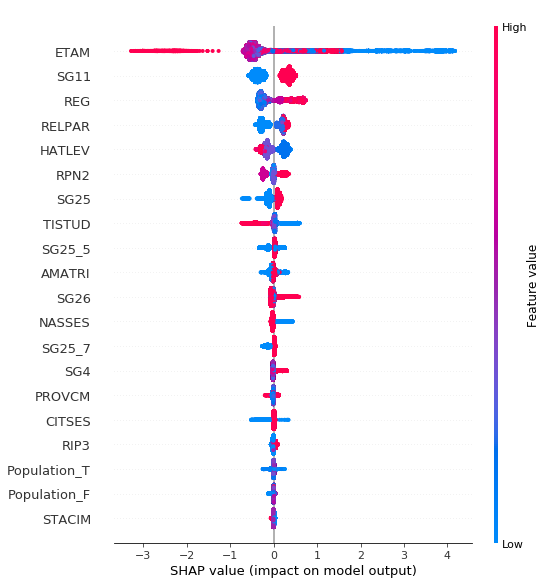

In [0]:
shap.initjs()
shap.summary_plot(shap_values, X_train)

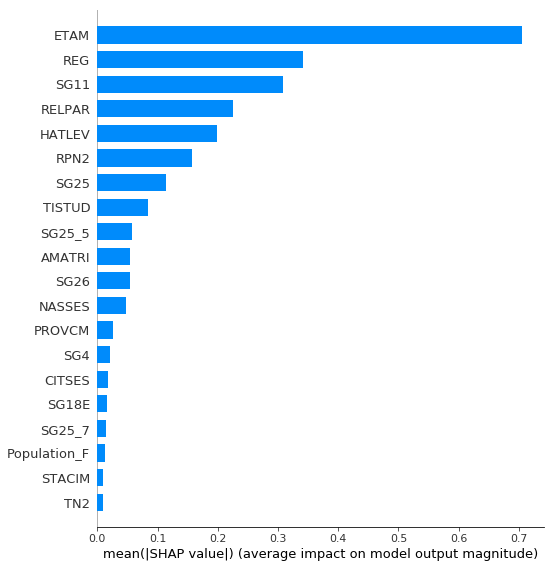

In [0]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

In [0]:
model_path

'/content/drive/My Drive/Colab Notebooks/Youth_Unemployment/data/individual_model'

In [0]:
pip install joblib

In [0]:
joblib.dump(XGB, os.path.join(model_path, 'models', 'XGBmodel.pkl'))

['/content/drive/My Drive/Colab Notebooks/Youth_Unemployment/data/individual_model/models/XGBmodel.pkl']